# atmodeller

## Science Cases

Following the Monte Carlo approach in 3_monte_carlo.ipynb, we sample the possible atmospheres of known exoplanets that can arise for different planetary conditions.


In [13]:
#from atmodeller import debug_logger
from typing import Type
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet, Species
from atmodeller.constraints import MassConstraint, IronWustiteBufferConstraintHirschmann, SystemConstraints, FugacityConstraint, PressureConstraint
from atmodeller.eos.holland import (
    CO2_CORK_simple_HP91,
    CO2_MRK_simple_HP91,
    get_holland_eos_models,
)
from atmodeller.eos.saxena import (
    get_saxena_eos_models
)
from atmodeller.interfaces import (
    GasSpecies,
    IdealGas,
    NoSolubility,
    RealGasABC,
    ThermodynamicData,
    ThermodynamicDataBase,
)
from atmodeller.solubilities import PeridotiteH2O, BasaltDixonCO2, BasaltLibourelN2, BasaltDixonH2O, BasaltS2, BasaltH2, BasaltCO
from atmodeller.utilities import earth_oceans_to_kg
import numpy as np
import csv
from atmodeller import debug_logger
import logging

thermodynamic_data: Type[ThermodynamicDataBase] = ThermodynamicData

eos_models_HP: dict[str, RealGasABC] = get_holland_eos_models()
eos_models_SS: dict[str, RealGasABC] = get_saxena_eos_models()

logger = debug_logger()
logger.setLevel(logging.INFO)


In [3]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

## Simulating Trappist-1 e

In [4]:
species: Species = Species()
species.append(GasSpecies(chemical_formula='H2O', solubility=BasaltDixonH2O()))
species.append(GasSpecies(chemical_formula='H2', solubility=BasaltH2()))
species.append(GasSpecies(chemical_formula='O2'))
species.append(GasSpecies(chemical_formula='CO'))
species.append(GasSpecies(chemical_formula='CO2', solubility=BasaltDixonCO2()))
species.append(GasSpecies(chemical_formula='N2', solubility=BasaltLibourelN2()))
species

Species([GasSpecies(chemical_formula='H2O', name_in_thermodynamic_data='H2O', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2O'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x124f2c8d0>, output=None, solubility=<atmodeller.solubilities.BasaltDixonH2O object at 0x124ea8810>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='H2', name_in_thermodynamic_data='H2', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x124c4a850>, output=None, solubility=<atmodeller.solubilities.BasaltH2 object at 0x124e79550>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='O2', name

In [4]:
planet: Planet = Planet(surface_temperature=270, mantle_mass = 3.249E24, surface_radius = 5.804E6)


In [5]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

### Vary fO2

In [6]:
species: Species = Species()
species.append(GasSpecies(chemical_formula='H2O', solubility=BasaltDixonH2O()))
species.append(GasSpecies(chemical_formula='H2', solubility=BasaltH2()))
species.append(GasSpecies(chemical_formula='O2'))
species.append(GasSpecies(chemical_formula='CO2', solubility=BasaltDixonCO2()))
species.append(GasSpecies(chemical_formula='CO'))

species

Species([GasSpecies(chemical_formula='H2O', name_in_thermodynamic_data='H2O', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2O'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x11a676790>, output=None, solubility=<atmodeller.solubilities.BasaltDixonH2O object at 0x11a676710>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='H2', name_in_thermodynamic_data='H2', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x11a6abf50>, output=None, solubility=<atmodeller.solubilities.BasaltH2 object at 0x1191b6390>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='O2', name

In [7]:
planet: Planet = Planet(surface_temperature=2000, mantle_mass = 3.249E24, surface_radius = 5.804E6, mantle_melt_fraction=1)
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [8]:
#Vary fO2:
number_of_realisations: int = 9

number_Earth_oceans: float = 1
# Parameters are normally distributed between bounds.
fo2_shifts: np.ndarray = np.arange(-4, 5)
print(fo2_shifts)
print(len(fo2_shifts))
print(fo2_shifts[8])

[-4 -3 -2 -1  0  1  2  3  4]
9
4


In [9]:
# Store the output in a list.
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_H: float = earth_oceans_to_kg(1)
    mass_C: float = mass_H/2
    constraints: SystemConstraints = SystemConstraints([
        MassConstraint(species="H", value=mass_H),
        MassConstraint(species="C", value=mass_C),
        IronWustiteBufferConstraintHirschmann(log10_shift=fo2_shifts[realisation])
    ])
    # Recall that changing attributes on the planet 'object' will be 'seen' by interior_atmosphere.
    interior_atmosphere.solve(constraints)
    #out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    
    H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    out_realisation: dict[str,float] = interior_atmosphere.solution_dict

    # Include the parameters in the output.

    out_realisation['H2_melt'] = H2_melt
    out_realisation['H2O_melt'] = H2O_melt
    out_realisation['O2_melt'] = O2_melt
    out_realisation['CO2_melt'] = CO2_melt
    out_realisation['CO_melt'] = CO_melt

    out_realisation['fo2_shift'] = fo2_shifts[realisation]

    out.append(out_realisation)

    filename: str = "data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)
    

Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv
Writing output to: %s data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv


In [10]:
import pandas as pd
datafile_fO2: str = f"data/science_cases_files/atmodeller_monte_carlo_varyfO2.csv"
df_fO2: pd.DataFrame = pd.read_csv(datafile_fO2, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO2_pp', 'CO_pp', 'H2O_melt', 'H2_melt', 'O2_melt', 'CO2_melt', 'CO_melt', 'fO2_shift'))

print(df_fO2.fO2_shift)

0   -4
1   -3
2   -2
3   -1
4    0
5    1
6    2
7    3
8    4
Name: fO2_shift, dtype: int64


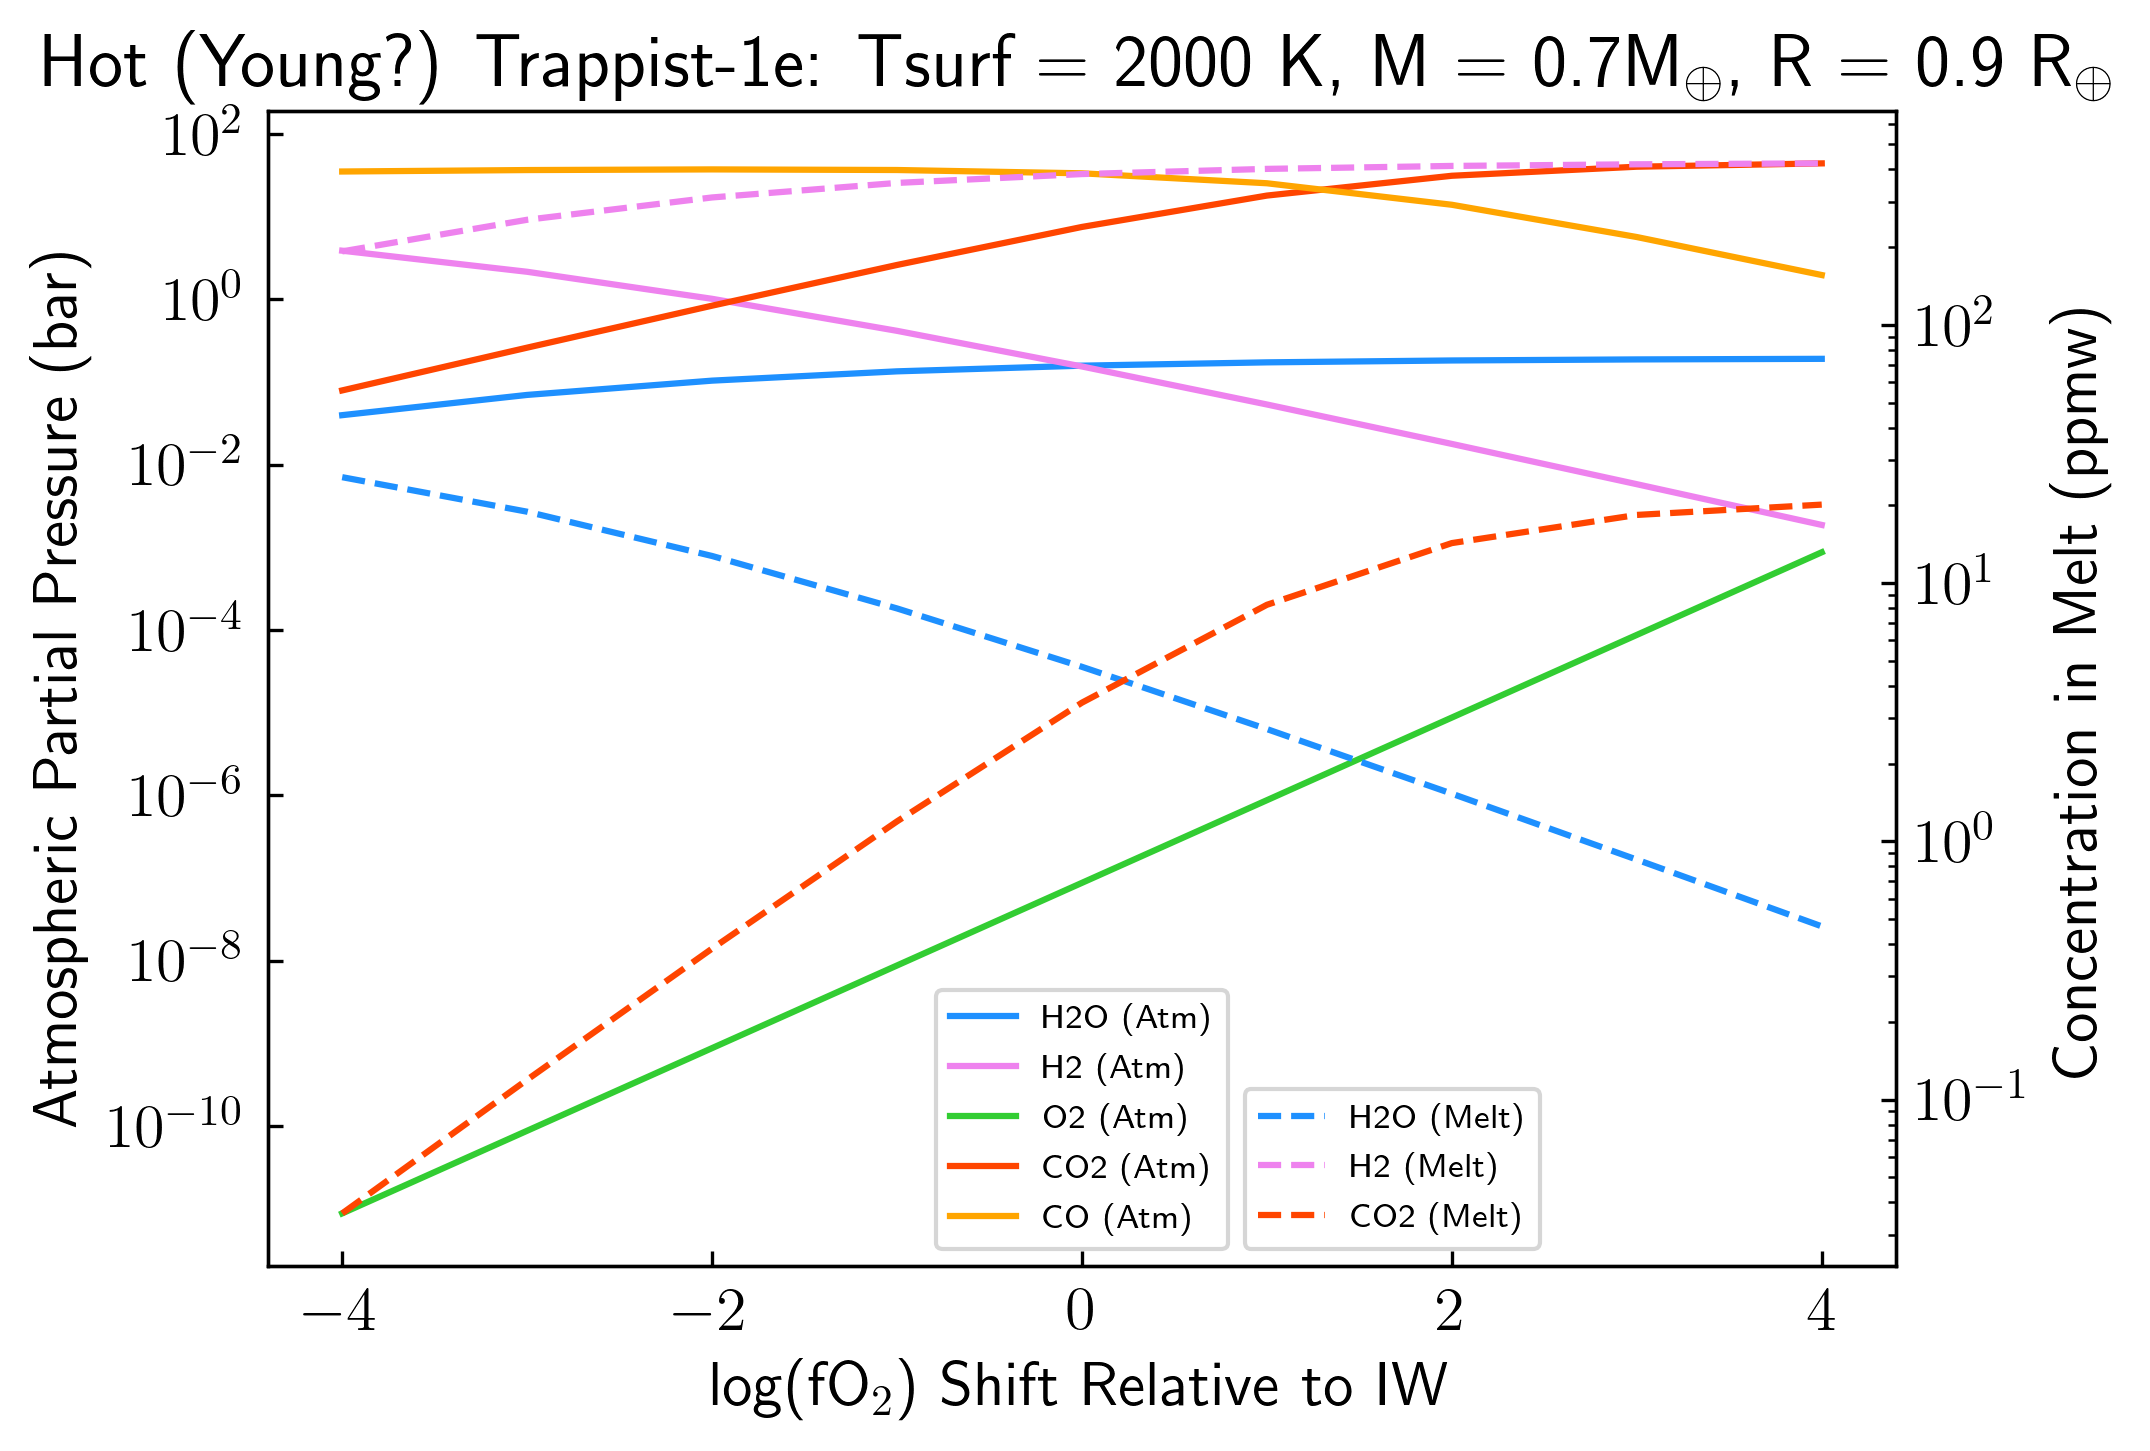

In [11]:
fig, ax = plt.subplots()
ax.plot(df_fO2.fO2_shift, df_fO2.H2O_pp, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.H2_pp, color='violet', label='H2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.O2_pp, color='limegreen', label='O2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO2_pp, color='orangered', label='CO2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO_pp, color='orange', label='CO (Atm)')

ax2 = ax.twinx()
ax2.plot(df_fO2.fO2_shift, df_fO2.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.CO_melt, color='orange', linestyle='--', label='CO (Melt)')

ax.set_xlabel(r'log(fO$_2$) Shift Relative to IW')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax2.set_yscale('log')
ax.legend(fontsize=8, loc=8)
ax2.legend(fontsize=8, loc=(0.6, 0.015))
plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 2000 K, M = 0.7M$_\oplus$, R = 0.9 R$_\oplus$')
#plt.savefig('data/Plots/PlanetTrial1_HotTrappist1e_CHO_2000K.jpg', dpi=1000)
plt.show()

## Simulating K2-18 b

In [14]:
planet: Planet = Planet(surface_temperature=1500, mantle_mass = 3.6315E25, surface_radius = 1.6647E7)
#planet: Planet = Planet()


In [15]:
species: Species = Species(
        [
            GasSpecies(
                chemical_formula="H2",
                solubility=BasaltH2(),
                thermodynamic_class=thermodynamic_data,
               # eos=IdealGas(),
            ),
            GasSpecies(
                chemical_formula="H2O",
                solubility=BasaltDixonH2O(),
                thermodynamic_class=thermodynamic_data,
               # eos=eos_models_HP["H2O"],
            ),
            GasSpecies(
                chemical_formula="O2",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["O2"]
            ),
            GasSpecies(
                chemical_formula="CO",
                solubility=BasaltCO(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO"],
            ),
            GasSpecies(
                chemical_formula="CO2",
                solubility=BasaltDixonCO2(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO2"],
            ),
            GasSpecies(
                chemical_formula="CH4",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CH4"],
            ),
        ]
    )

[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[13:37:11 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies


In [70]:
oceans: float = 10
h_kg: float = earth_oceans_to_kg(oceans)
c_kg: float = h_kg

constraints: SystemConstraints = SystemConstraints(
    [
        FugacityConstraint(species="H2", value=958),
        IronWustiteBufferConstraintHirschmann(),
        MassConstraint(species="C", value=c_kg),
    ]
)

system: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [71]:
initial_solution: np.ndarray = np.array([1000, 1000, 1e-8, 100, 10, 1])
system.solve(constraints, initial_solution=initial_solution)

In [72]:
system.output

{'temperature': 2000,
 'total_pressure_in_atmosphere': 2026.6981086063047,
 'mean_molar_mass_in_atmosphere': 0.010667466253504542,
 'H2': GasSpeciesOutput(mass_in_atmosphere=5.079421345277659e+21, mass_in_solid=0.0, mass_in_melt=1.6732962580062393e+22, moles_in_atmosphere=2.5197017212702226e+24, moles_in_melt=8.30056649152202e+24, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=460.7727545108741, fugacity=957.9999999999998, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=958.0000000000001, volume_mixing_ratio=0.47269003505351176, mass_in_total=2.1812383925340054e+22),
 'H2O': GasSpeciesOutput(mass_in_atmosphere=4.900071852467356e+22, mass_in_solid=0.0, mass_in_melt=1.1269436003070279e+24, moles_in_atmosphere=2.7199521453459807e+24, moles_in_melt=6.255485134969139e+25, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=31032.454916894614, fugacity=1034.1359587308082, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=1034.1359587308086, volume_mixing_ra

In [16]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [18]:
#Vary amount of H (expressed as Earth oceans)

number_of_realisations: int = 191

number_Earth_oceans_arr: np.ndarray = np.arange(1,16)

#print(number_Earth_oceans_arr)

#Vary abount of H in atmosphere:
H2_fugacity_arr: np.ndarray = np.arange(1000, 20100, 100)
print((float(H2_fugacity_arr[0])))

1000.0


In [71]:
#intial solution array:

CO2_fugacity_arr: np.ndarray = 5*np.ones(191)


191


In [19]:
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_C: float = earth_oceans_to_kg(10)
    H2_fug = H2_fugacity_arr[realisation]
    constraints: SystemConstraints = SystemConstraints([
        FugacityConstraint(species="H2", value=H2_fug),
        FugacityConstraint(species="CO2", value=5),
        IronWustiteBufferConstraintHirschmann()
    ])
    
    initial_solution: np.ndarray = np.array([H2_fug, 10000, 1e-12, 5, 5, 400])
    # Recall that changing attributes on the planet 'object' will be 'seen' by interior_atmosphere.
    interior_atmosphere.solve(constraints, factor=1, tol = 1e-6, initial_solution=initial_solution)
    #out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    
    H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    out_realisation: dict[str,float] = interior_atmosphere.solution_dict

    # Include the parameters in the output.

    out_realisation['H2_melt'] = H2_melt
    out_realisation['H2O_melt'] = H2O_melt
    out_realisation['O2_melt'] = O2_melt
    out_realisation['CO2_melt'] = CO2_melt
    out_realisation['CO_melt'] = CO_melt

    out_realisation['H2_fugacity'] = H2_fugacity_arr[realisation]

    out.append(out_realisation)

    filename: str = "data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)

Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv
Writing output to: %s data/sci

SystemExit: 

/Users/maggiethompson/Programs/atmodeller/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [36]:
import pandas as pd
datafile_K218b_try: str = f"data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_RealGas_1500K.csv"
df_K218b_try: pd.DataFrame = pd.read_csv(datafile_K218b_try, skiprows=1, names=('H2','H2O','O2','CO','CO2','CH4','H2_melt','H2O_melt','O2_melt','CO2_melt','CO_melt','H2_fugacity'))

print(df_K218b_try)

               H2          H2O            O2         CO       CO2        CH4  \
0      727.090289   871.998239  2.875121e-12   8.958093  3.168227  42.060462   
1      777.359621   960.098892  2.910307e-12   8.557061  3.050008  48.282206   
2      824.746990  1047.884999  2.945157e-12   8.184113  2.939044  54.586422   
3      869.491261  1135.167414  2.979655e-12   7.836838  2.834786  60.940691   
4      911.792552  1221.912316  3.013810e-12   7.512805  2.736651  67.316499   
..            ...          ...           ...        ...       ...        ...   
186  45701.545874  1777.284296  1.376980e-10   0.000466  0.000252   0.032963   
187  45672.305072  1787.992747  1.374827e-10   0.000468  0.000253   0.033450   
188  45643.123591  1798.713155  1.372686e-10   0.000469  0.000253   0.033941   
189  45614.000747  1809.445494  1.370557e-10   0.000470  0.000254   0.034437   
190  20000.000000    10.000000  1.370557e-10  10.000000  5.000000  10.000000   

         H2_melt       H2O_melt  O2_mel

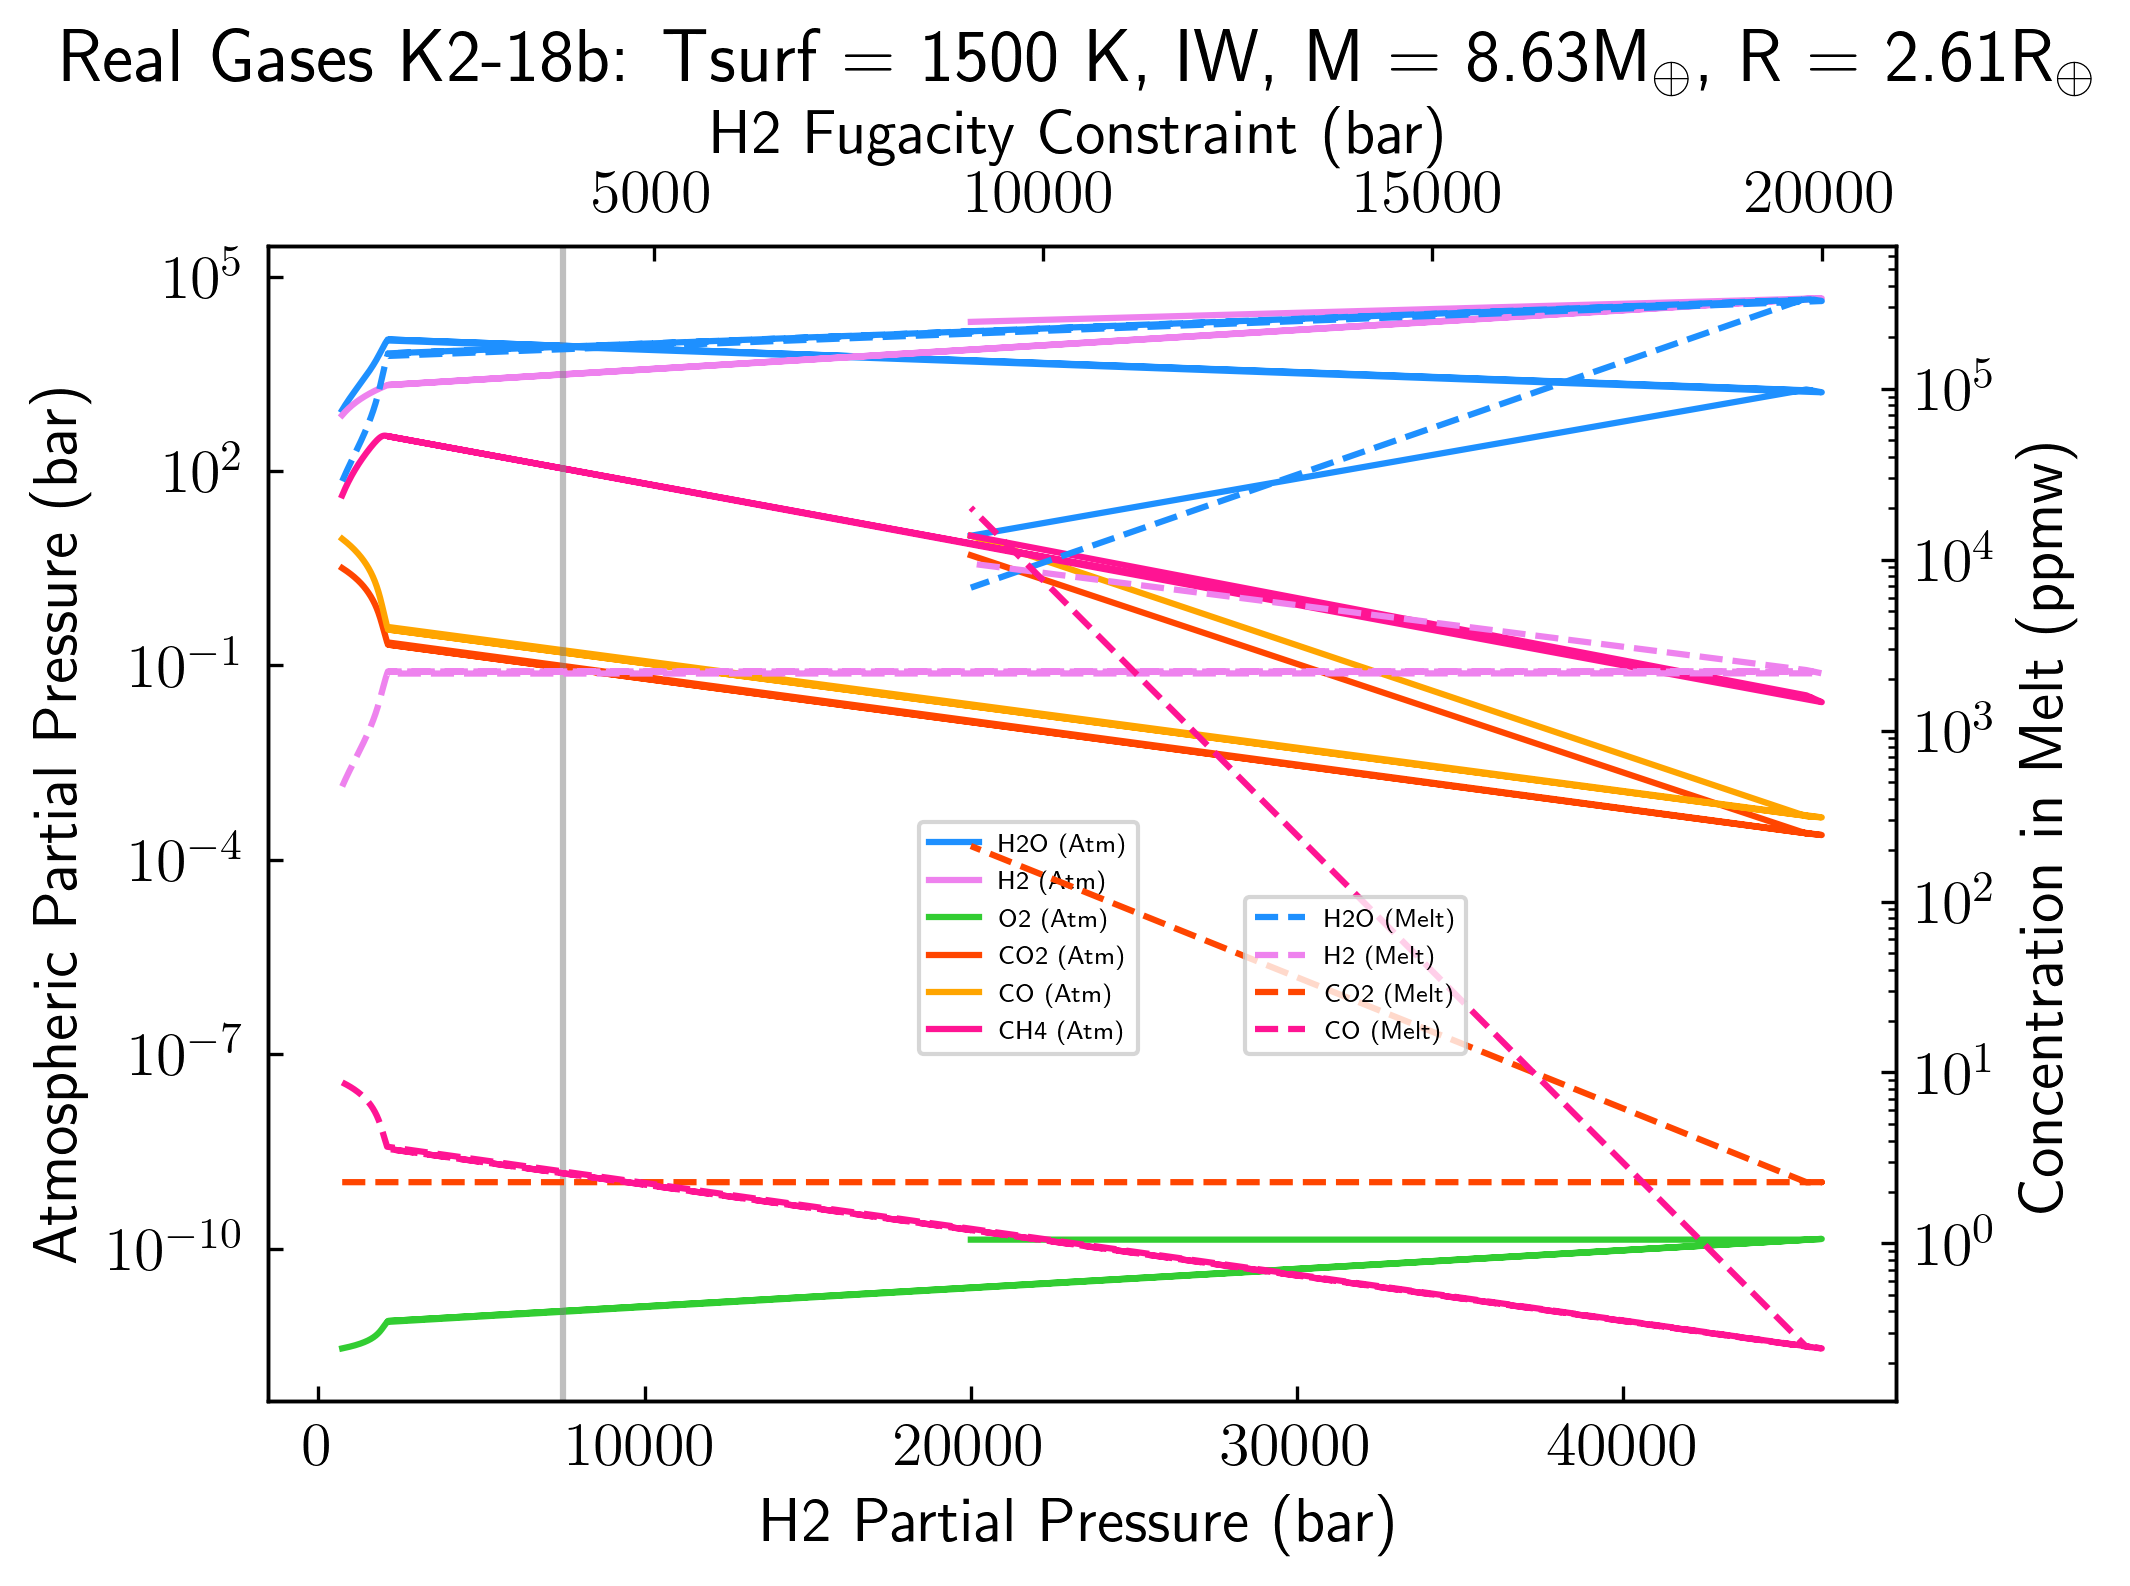

In [37]:
fig, ax = plt.subplots()
ax.plot(df_K218b_try.H2, df_K218b_try.H2O, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.H2, color='violet', label='H2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.O2, color='limegreen', label='O2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CO2, color='orangered', label='CO2 (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CO, color='orange', label='CO (Atm)')
ax.plot(df_K218b_try.H2, df_K218b_try.CH4, color='deeppink', label='CH4 (Atm)')


ax2 = ax.twinx()
ax2.plot(df_K218b_try.H2, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
ax2.plot(df_K218b_try.H2, df_K218b_try.CO_melt, color='deeppink', linestyle='--', label='CO (Melt)')
ax.axvline(x=7500, color='gray', alpha=0.5)
ax3 = ax.twiny()
ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2, alpha=0)
ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Partial Pressure (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax2.set_yscale('log')

ax.legend(fontsize=6, loc=(0.4, 0.3))
ax2.legend(fontsize=6, loc=(0.6, 0.3))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa.jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [28]:
print(df_K218b_try.CO)

0      7.273294
1      6.337788
2      5.565684
3      4.924222
4      4.387432
         ...   
186    0.114634
187    0.253518
188    0.094859
189    0.137936
190    0.284494
Name: CO, Length: 191, dtype: float64


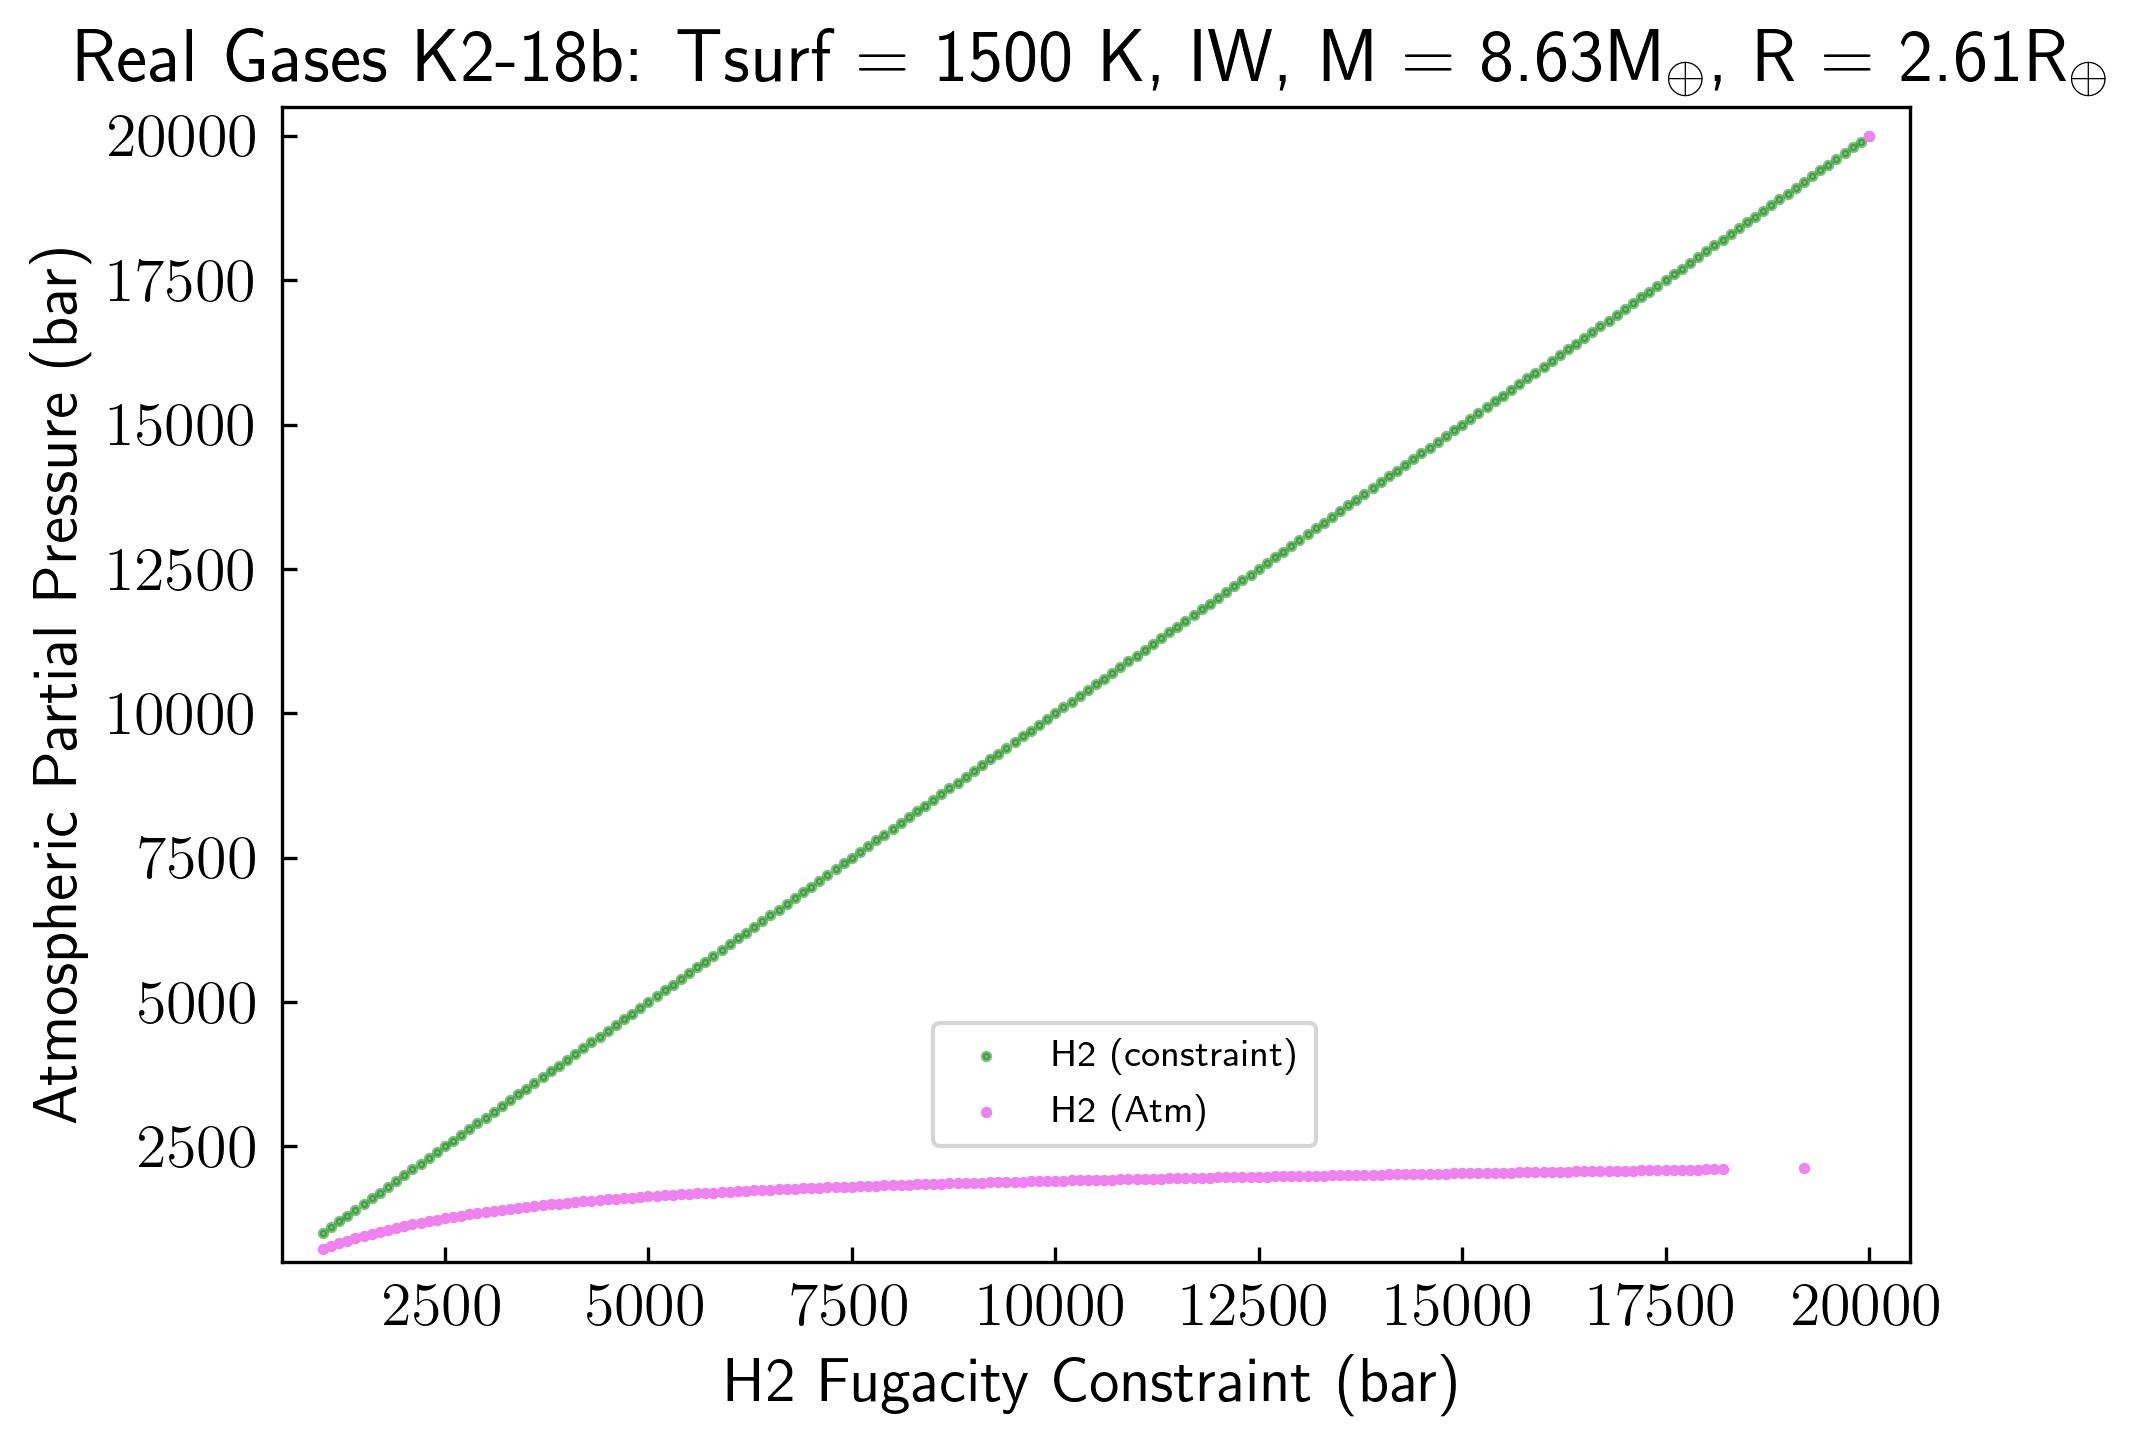

In [38]:
fig, ax = plt.subplots()
#ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2O, s=3, color='dodgerblue', label='H2O (Atm)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2_fugacity, s=3, color='green', alpha=0.5, label='H2 (constraint)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2, s=3, color='violet', label='H2 (Atm)')

#ax2 = ax.twinx()
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
ax.set_xlim(500,20500)
ax.set_ylim(500,20500)

#ax3 = ax.twiny()
#ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2)
#ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
#ax2.set_ylabel('Concentration in Melt (ppmw)')
#ax.set_yscale('log')
#ax2.set_yscale('log')

ax.legend(fontsize=9, loc=(0.4, 0.1))
ax2.legend(fontsize=6, loc=(0.6, 0.1))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa_H2Check_onlyFugacityConstraints.jpg', dpi=1000, bbox_inches='tight')
plt.show()